### Objective  

**Using Random Forest before feature selection**

In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold 

pd.set_option('display.max_columns', None)

> retrieve data

In [2]:
X_train = pd.read_csv('cache/4-X_train-upsampled.csv')
y_train = pd.read_csv('cache/4-y_train-upsampled.csv')
X_test = pd.read_csv('cache/4-X_test-upsampled.csv')
y_test = pd.read_csv('cache/4-y_test-upsampled.csv')

In [12]:

X_train_num = X_train.select_dtypes(include = np.number)
X_test_num = X_test.select_dtypes(include = np.number)
X_train_cat = X_train.select_dtypes(include = object)
X_test_cat = X_test.select_dtypes(include = object)

#SCALE
# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the scaler on training numerical data
X_train_scaled_num = scaler.fit_transform(X_train_num)

# Transform the test numerical data using the same scaler
X_test_scaled_num = scaler.transform(X_test_num)

# Create DataFrames for scaled numerical data
X_train_scaled_num_df = pd.DataFrame(X_train_scaled_num, columns=X_train_num.columns)
X_test_scaled_num_df = pd.DataFrame(X_test_scaled_num, columns=X_test_num.columns)

# ENCODE
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
encoder.fit(X_train_cat)

# Transform the data using the fitted encoder
X_train_cat_encoded = encoder.transform(X_train_cat)
X_train_cat_encoded_df = pd.DataFrame(X_train_cat_encoded, columns=X_train_cat.columns)

X_test_cat_encoded = encoder.transform(X_test_cat)
X_test_cat_encoded_df = pd.DataFrame(X_test_cat_encoded, columns=X_test_cat.columns)

# Concatenate the scaled numerical data with the encoded categorical data
X_train = pd.concat([X_train_scaled_num_df, X_train_cat_encoded_df], axis=1)
X_test = pd.concat([X_test_scaled_num_df, X_test_cat_encoded_df], axis=1)

/var/folders/pr/f4jl4tln3yn9fd_1yjrwwkp40000gn/T/ipykernel_26433/3121453162.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)


0.6214506399882301
0.6204251037605333


TARGET_B
0           22599
1            1254
Name: count, dtype: int64

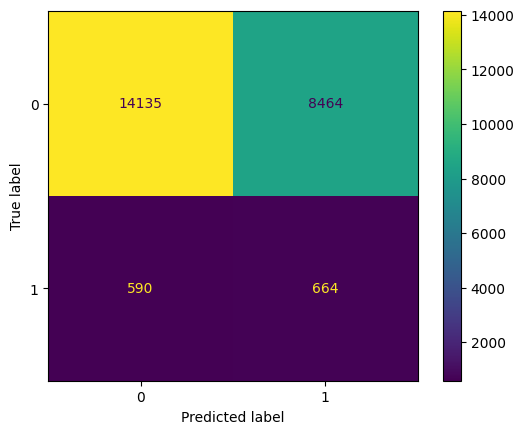

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

clf = RandomForestClassifier(max_depth=5, # max number of questions to ask
                             min_samples_split=20, # amount of rows still considered at every question
                             min_samples_leaf =20, # ultimate answer based on at least this many rows
                             max_samples=0.8, # fraction of X-train to use in each tree
                             random_state=42)
clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

y_pred = clf.predict(X_test)
display(y_test.value_counts())

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
cm_display.plot()

## select features based on variance

> scale using min-max-scaler! 

In [22]:
var_threshold = 0.01
sel = VarianceThreshold(threshold=var_threshold)

# Fit the VarianceThreshold selector only on the training data
sel.fit(X_train)

# Get the indices of the selected features
selected_indices_train = sel.get_support(indices=True)

# Get the selected column names for training data
selected_columns_train = X_train.columns[selected_indices_train]

# Transform both the training and test data using the same selector
X_var_train = pd.DataFrame(sel.transform(X_train), columns=selected_columns_train)
X_var_test = pd.DataFrame(sel.transform(X_test), columns=selected_columns_train)  # Use the same selected columns as training data

In [29]:
selected_columns_train.to_list()

['ODATEDW',
 'AGE',
 'NUMCHLD',
 'MBBOOKS',
 'PUBHLTH',
 'MALEVET',
 'VIETVETS',
 'WWIIVETS',
 'WEALTH2',
 'POP90C1',
 'POP90C2',
 'POP90C3',
 'ETH1',
 'ETH2',
 'ETH5',
 'ETH13',
 'HHAGE1',
 'HHAGE3',
 'HHN1',
 'HHN3',
 'HHN4',
 'MARR1',
 'DW1',
 'DW2',
 'DW4',
 'DW5',
 'DW6',
 'HV1',
 'HV2',
 'HV3',
 'HV4',
 'HU1',
 'HU2',
 'HU3',
 'HU4',
 'HU5',
 'HHD1',
 'HHD2',
 'HHD3',
 'HHD4',
 'HHD5',
 'HHD6',
 'ETHC2',
 'ETHC3',
 'HVP1',
 'HVP2',
 'HVP3',
 'HVP4',
 'HVP5',
 'HVP6',
 'HUR2',
 'RHP1',
 'RHP2',
 'HUPA1',
 'HUPA2',
 'HUPA3',
 'HUPA6',
 'RP1',
 'RP2',
 'RP3',
 'RP4',
 'DMA',
 'IC1',
 'IC2',
 'IC3',
 'IC4',
 'IC6',
 'IC15',
 'IC19',
 'HHAS1',
 'HHAS3',
 'MC1',
 'MC2',
 'MC3',
 'TPE1',
 'PEC2',
 'TPE13',
 'LFC1',
 'LFC2',
 'LFC3',
 'LFC4',
 'LFC5',
 'LFC6',
 'LFC7',
 'LFC8',
 'LFC9',
 'EIC4',
 'OEDC5',
 'EC1',
 'EC4',
 'AFC5',
 'VC1',
 'VC3',
 'VC4',
 'POBC1',
 'POBC2',
 'LSC1',
 'LSC2',
 'VOC1',
 'VOC2',
 'VOC3',
 'HC1',
 'HC2',
 'HC4',
 'HC5',
 'HC6',
 'HC7',
 'HC8',
 'HC11',
 'HC12

/var/folders/pr/f4jl4tln3yn9fd_1yjrwwkp40000gn/T/ipykernel_26433/2187453677.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_var_train, y_train)


0.6198175665734883
0.6271328554060286


TARGET_B
0           22599
1            1254
Name: count, dtype: int64

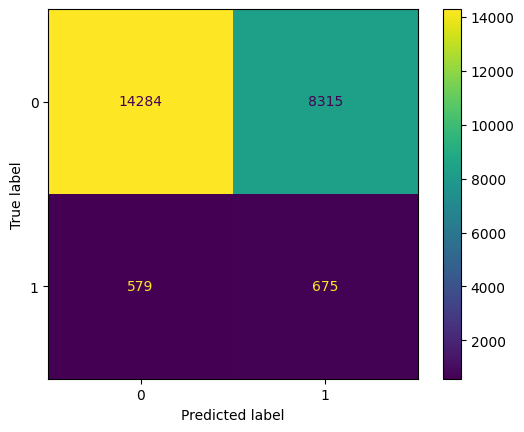

In [23]:
clf = RandomForestClassifier(max_depth=5, # max number of questions to ask
                             min_samples_split=20, # amount of rows still considered at every question
                             min_samples_leaf =20, # ultimate answer based on at least this many rows
                             max_samples=0.8, # fraction of X-train to use in each tree
                             random_state=42)
clf.fit(X_var_train, y_train)
print(clf.score(X_var_train, y_train))
print(clf.score(X_var_test, y_test))

y_pred = clf.predict(X_var_test)
display(y_test.value_counts())

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
cm_display.plot()

In [25]:
from sklearn.model_selection import cross_val_score
recall_scores = cross_val_score(clf, X_train, y_train, cv=10, scoring='recall_macro')

/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector 

In [26]:
recall_scores

array([0.6103428 , 0.62277475, 0.61703693, 0.62328969, 0.61836104,
       0.62137708, 0.61659556, 0.61107842, 0.61468295, 0.62270119])

In [30]:
from sklearn.metrics import make_scorer, recall_score
from scipy.stats import randint

# Define the Random Forest classifier
rf_classifier = RandomForestClassifier()
from sklearn.model_selection import RandomizedSearchCV

# Define the hyperparameter grid
param_dist = {
    'n_estimators': randint(50, 200),  # Number of trees in the forest
    'max_depth': randint(5, 50),        # Maximum depth of the trees
    'min_samples_split': randint(2, 20), # Minimum number of samples required to split a node
    'min_samples_leaf': randint(1, 20),  # Minimum number of samples required at each leaf node
    'max_features': ['auto', 'sqrt'],   # Number of features to consider at each split
    'bootstrap': [True, False]          # Whether bootstrap samples are used when building trees
}

# Define a custom scorer for recall
scorer = make_scorer(recall_score)

# Define RandomizedSearchCV with recall as the scoring metric
random_search_recall = RandomizedSearchCV(estimator=rf_classifier, 
                                          param_distributions=param_dist, 
                                          n_iter=100,
                                          cv=5,
                                          scoring=scorer,  # Use recall as the scoring metric
                                          random_state=42)

# Perform the Randomized Search
random_search_recall.fit(X_var_train, y_train)

# Get the best parameters
best_params_recall = random_search_recall.best_params_
print("Best parameters for recall optimization:", best_params_recall)

# Get the best model
best_model_recall = random_search_recall.best_estimator_

# Evaluate the best model on test data
test_recall = recall_score(y_test, best_model_recall.predict(X_var_test))
print("Test Recall:", test_recall)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_fo

In [ ]:
# Concatenate the full dataset
X_full = pd.concat([X_train, X_test], axis=0)
y_full = pd.concat([y_train, y_test], axis=0)

# Train the final model using the best parameters found
tagert_b_model = RandomForestClassifier(**best_params_recall)  # Using the best parameters found

# Train the final model on the full dataset
tagert_b_model.fit(X_full, y_full)

In [ ]:
import pickle

# Save the trained model to a file
with open('tagert_b_model.pkl', 'wb') as file:
    pickle.dump(tagert_b_model, file)

In [ ]:
# Load the saved model from the file
with open('final_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)